In [1]:
import pandas as pd
import numpy as np
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Defining Features and Classifier

In [2]:
df_high = pd.read_csv("Fire_high.csv", index_col=False)

In [3]:
df_high.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,0,5,29


In [4]:
X = df_high.drop("Horizontal_Distance_To_Fire_Points",axis=1)
y = df_high["Horizontal_Distance_To_Fire_Points"]

In [5]:
#Splitting the set (test = 0.3) in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y, random_state=4444)

In [6]:
#scaling the features
sca = StandardScaler()
sca.fit_transform(X_train)
sca.transform(X_test);

In [7]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [8]:
def grid_estimator(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=1)
    grid.fit(X_train, y_train)
    print("Accuracy training: " + str(grid.best_score_))
    y_pred = grid.predict(X_test)
    print("Accuracy test: " + str(accuracy_score(y_pred,y_test)))
    print("Recall test: " + str(recall_score(y_pred,y_test)))
    print("Precision test: " + str(precision_score(y_pred,y_test)))
    print("F1 score test: " + str(f1_score(y_pred,y_test)))
    print(grid.best_estimator_)


In [17]:
def conf_trees(y, y_pred):
    trees_confusion = confusion_matrix(y, y_pred)
    plt.figure(dpi=180)
    sns.heatmap(trees_confusion, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 16}, square=True, fmt='d',
               xticklabels=["0","2"],
               yticklabels=["0","2"]);
    plt.tick_params(axis="both", labelsize=14)
    plt.xlabel('prediction', fontsize = 14)
    plt.ylabel('actual', fontsize = 14);

### Hyperparameter tunning

In [9]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, X_train, y_train, X_test, y_test)

Accuracy training: 0.9456342142274063
Accuracy test: 0.9538335322195705
Recall test: 0.9594729325536903
Precision test: 0.8447686832740213
F1 score test: 0.8984746596686894
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [10]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
feature_viewer = {}
for col, score in zip(X.loc[:,:].columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Elevation                           0.222499
Aspect                              0.057983
Slope                               0.040660
Horizontal_Distance_To_Hydrology    0.076538
Vertical_Distance_To_Hydrology      0.086907
Horizontal_Distance_To_Roadways     0.192352
Hillshade_9am                       0.048742
Hillshade_Noon                      0.053034
Hillshade_3pm                       0.052730
Cover_Type                          0.050194
Soil_Type                           0.118361
dtype: float64

In [11]:
X_train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Cover_Type',
       'Soil_Type'],
      dtype='object')

In [13]:
param_grid = {}
col_out = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type"]
X_train_out = X_train.drop(col_out, axis = 1)
X_test_out = X_test.drop(col_out, axis = 1)
grid_estimator(RandomForestClassifier(), param_grid, X_train_out, y_train, X_test_out, y_test)

Accuracy training: 0.778964269205425
Accuracy test: 0.7815483293556086
Recall test: 0.5907652538218122
Precision test: 0.3144721233689205
F1 score test: 0.41045411615340543
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [10]:
#Droping feature importances < 0.7
param_grid = {}
col_in = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]
grid_estimator(RandomForestClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)

Accuracy training: 0.9421501421167029
Accuracy test: 0.9480390581971727
Recall test: 0.9358356380877124
Precision test: 0.8429181494661921
F1 score test: 0.8869500093615428
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [24]:
param_grid = {'n_estimators': [10,100], 'max_depth': [50,100], 'max_leaf_nodes':[100000,1000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)

Accuracy training: 0.952737590605545
Accuracy test: 0.9562947494033412
Recall test: 0.9355261830289577
Precision test: 0.8799051008303678
F1 score test: 0.906863584125975
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [25]:
param_grid = {'n_estimators': [100,200], 'max_depth': [50,100], 'max_leaf_nodes':[5000000, 10000000, 15000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)

Accuracy training: 0.9531088643449355
Accuracy test: 0.9568684597025886
Recall test: 0.9359955685366099
Precision test: 0.8819454329774614
F1 score test: 0.9081670046173014
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Oversampling with best model with SMOTE

In [20]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train_in,y_train)

In [12]:
rf = RandomForestClassifier(max_leaf_nodes=10000000, max_depth=100, n_estimators=200)
rf.fit(X_smoted, y_smoted)
y_pred = rf.predict(X_test_in)

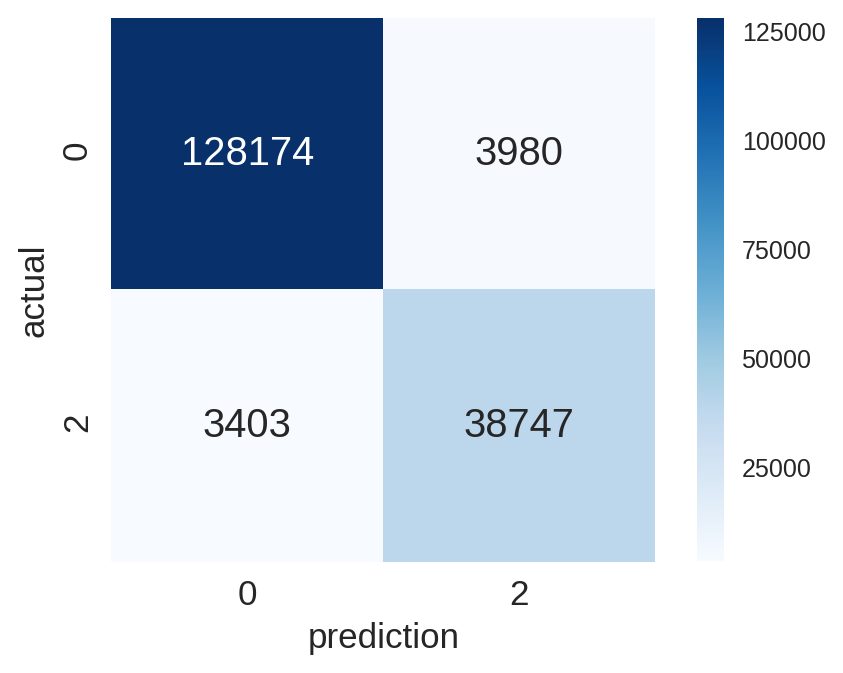

In [18]:
conf_trees(y_test, y_pred)

In [15]:
print("Recall for cover:")
for i in range(2):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:96.9883620624423
Type 1:91.926453143535


In [19]:
print("Precision for cover:")
for i in range(2):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:97.4136817224895
Type 1:90.68504692583144


### Fitting with the whole data set

In [21]:
X_SMOTE_all, y_SMOTE_all = SMOTE(random_state=42).fit_sample(X_in,y)

In [22]:
rf = RandomForestClassifier(max_leaf_nodes=10000000, max_depth=100, n_estimators=200)
rf.fit(X_SMOTE_all, y_SMOTE_all)
y_pred = rf.predict(X_in)

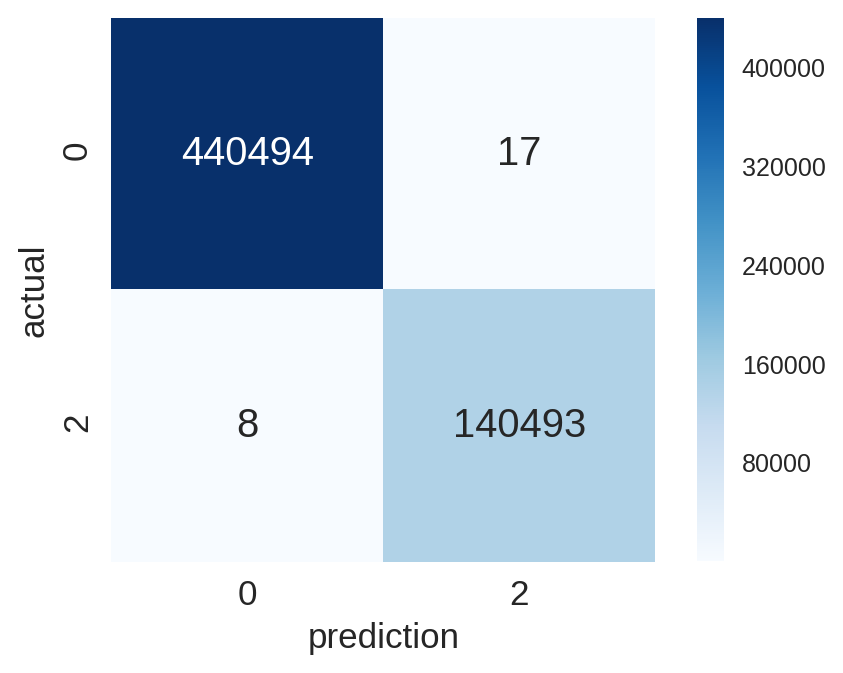

In [23]:
conf_trees(y, y_pred)

In [24]:
print("Recall for cover:")
for i in range(2):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y[y==(i)])))

Recall for cover:
Type 0:99.99614084551804
Type 1:99.99430609034812


In [26]:
print("Precision for cover:")
for i in range(2):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:99.998183890198
Type 1:99.98790121699523
